In [148]:
PATH =  "fedavg_cnn_uniform_exp_v0"
#  "fedavg_cnn_classdis_exp_v1"

In [149]:
import tensorflow as tf
import sys
import os
sys.path.append("../")

from federated.data.data_preprocessing import load_data
import numpy as np
from matplotlib import pyplot as plt
import itertools
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc, confusion_matrix
from tensorflow.python.summary.summary_iterator import summary_iterator
from collections import defaultdict
import pandas as pd

pd.options.plotting.backend = "plotly"

%matplotlib inline

In [150]:
import nest_asyncio
nest_asyncio.apply()

In [151]:
"""
Function that evaluates the model.
Prints accuracy and loss value
"""
def evaluation(X, y, model):
    scores = model.evaluate(X, y, verbose=0)
    print(f"Accuracy: {scores[1]*100}%, Loss: {scores[0]}")

In [152]:
LABELS = ["N", "S", "V", " F", "U"]

In [153]:
"""
Function that creates confusion matrix based upon the dataset and the model.
Displays the confusion matrix.
"""

def make_confusion_matrix(X,y, model):
    y_pred = model.predict(X)
    y_test = np.argmax(y, axis=1)
    y_pred = np.argmax(y_pred, axis=1)

    cnf_matrix = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(15,15))
    cnf_matrix =  cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
    plt.imshow(cnf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Normalized Confusion Matrix")
    plt.colorbar()
    ticks = np.arange(len(LABELS))
    plt.xticks(ticks, LABELS, rotation=45)
    plt.yticks(ticks, LABELS)

    for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        plt.text(j,i,format(cnf_matrix[i,j], '.2f'), horizontalalignment="center",
                    color="white" if cnf_matrix[i, j] > cnf_matrix.max()/2 else "black")

    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")


    plt.show()

    return y_test, y_pred

In [154]:
"""
Function that loads model and dataset for analysis
Returns x_test, y_test and model
"""
def load(name):
    model = tf.keras.models.load_model("../history/logdir/" + name)
    X_test, y_test = load_data(data_analysis=True)

    X_test = X_test.reshape(len(X_test), X_test.shape[1],1)
    # X_test.shape
    evaluation(X_test, y_test, model)
    
    return X_test, y_test, model

In [155]:
def dataframe_from_event(path, type):

    path += f"{type}/"
    event_files = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]
    event_files = list(filter(lambda f: "empty" not in f, event_files))
    path += event_files[0]

    metrics = defaultdict(list)
    for e in summary_iterator(path):
        for v in e.summary.value:
            if isinstance(v.simple_value, float) and ("loss" in v.tag or "accuracy" in v.tag):
                if v.simple_value == 0.0:
                    metrics[f"{v.tag}_{type}"].append(tf.make_ndarray(v.tensor))
                else:
                    metrics[f"{v.tag}_{type}"].append(v.simple_value)
    metrics_df = pd.DataFrame({k: v for k,v in metrics.items() if len(v) > 1})

    return metrics_df

In [156]:
def plot_graph(type):
    
    if type not in ["accuracy", "loss"]:
        raise ValueError(f"type must be accuracy or loss, not {type}")

    path = f"../history/logdir/{PATH}/"
    train_df = dataframe_from_event(path, "train")
    validation_df = dataframe_from_event(path, "validation")

    cols = list(train_df.columns) + list(validation_df.columns)

    return pd.concat([train_df, validation_df], axis=1)[[col for col in cols if type in col]]

In [157]:
X_test, y_test, model_centralized = load(PATH)

model_centralized.summary()

Accuracy: 95.24483680725098%, Loss: 0.2026747316122055
Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_64 (Conv1D)           (None, 180, 16)           128       
_________________________________________________________________
leaky_re_lu_80 (LeakyReLU)   (None, 180, 16)           0         
_________________________________________________________________
max_pooling1d_32 (MaxPooling (None, 90, 16)            0         
_________________________________________________________________
conv1d_65 (Conv1D)           (None, 86, 16)            1296      
_________________________________________________________________
leaky_re_lu_81 (LeakyReLU)   (None, 86, 16)            0         
_________________________________________________________________
conv1d_66 (Conv1D)           (None, 82, 16)            1296      
________________________________________________________________

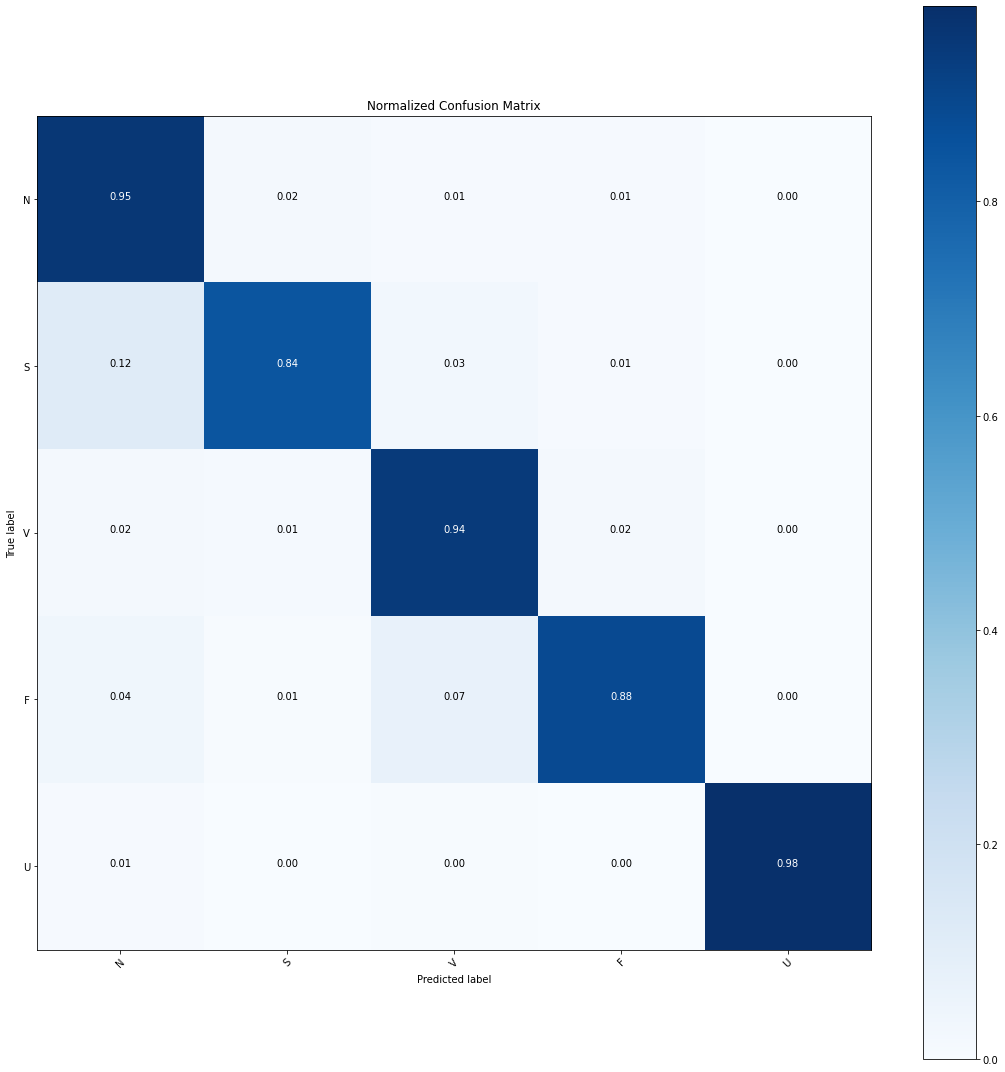

In [158]:
y_test, y_pred = make_confusion_matrix(X_test, y_test, model_centralized)

In [159]:
print(classification_report(y_test, y_pred, target_names=LABELS))

              precision    recall  f1-score   support

           N       0.99      0.95      0.97     18118
           S       0.52      0.84      0.64       556
           V       0.86      0.94      0.90      1448
           F       0.41      0.88      0.56       162
           U       0.97      0.98      0.97      1608

    accuracy                           0.95     21892
   macro avg       0.75      0.92      0.81     21892
weighted avg       0.97      0.95      0.96     21892



In [160]:
metrics_df = plot_graph("accuracy")
metrics_df.plot(title="Epoch Accuracy", labels=dict(index="epochs", value="accuracy", variable="option"))

In [161]:
metrics_df = plot_graph("loss")
metrics_df.plot(title="Epoch Loss", labels=dict(index="epochs", value="loss", variable="option"))